In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import random
import re
from tqdm import tqdm
import json
from collections import defaultdict

In [2]:
# cache_dir = "/mnt/SSD4/kartik/hf_cache"
model_name = "Qwen/Qwen3-1.7B"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=2048, out_features=6144, bias=False)
          (up_proj): Linear(in_features=2048, out_features=6144, bias=False)
          (down_proj): Linear(in_features=6144, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [3]:

# -------- Residual capture logic --------
residuals = defaultdict(dict)  # residuals[layer]["pre" or "post"] = tensor

def make_hook(layer_idx, mode="both"):
    def hook_pre(module, inputs):
        if mode in ("pre", "both"):
            residuals[layer_idx]["pre"] = inputs[0].clone()

    def hook_post(module, inputs, output):
        if mode in ("post", "both"):
            if isinstance(output, tuple):
                hidden_states = output[0]
            else:
                hidden_states = output
            residuals[layer_idx]["post"] = hidden_states.clone()

    return hook_pre, hook_post

# Register hooks
mode = "both"  # "pre", "post", or "both"
for i, block in enumerate(model.model.layers):
    hook_pre, hook_post = make_hook(i, mode=mode)
    block.register_forward_pre_hook(hook_pre)
    block.register_forward_hook(hook_post)

In [ ]:
QWEN_CHAT_TEMPLATE = "<|im_start|>user\n{prompt}\n<|im_end|>\n<|im_start|>assistant\n"

def format_prompt(prompt):
    return QWEN_CHAT_TEMPLATE.format(prompt=prompt)

In [19]:
model.eoi_tokens

AttributeError: 'Qwen3ForCausalLM' object has no attribute 'eoi_tokens'

In [5]:
dataset = load_dataset("gsm8k", "main")
n = 2
random.seed(0)
indices = random.sample(range(len(dataset['train'])), n)
qa_pairs = dataset['train'][indices]
questions = qa_pairs['question']
answers = qa_pairs['answer']

import re
final_answers = []
for answer in answers:
    numbers = re.findall(r'\d+', answer)
    final_answers.append(int(numbers[-1]) if numbers else '')

In [ ]:
all_residuals = []
residuals = defaultdict(dict)

for i, prompt in enumerate(tqdm(questions)):
    residuals.clear()    
    formatted_prompt = format_prompt(prompt)
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        out = model(**inputs)
    all_residuals.append(dict(residuals))


all_residuals_nothink = []
residuals = defaultdict(dict)

for i, prompt in enumerate(tqdm(questions)):
    prompt = prompt + "/nothink"
    residuals.clear()    
    formatted_prompt = format_prompt(prompt)
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        out = model(**inputs)
    all_residuals_nothink.append(dict(residuals))

100%|██████████| 2/2 [00:00<00:00, 20.05it/s]


In [17]:
all_residuals[0][27]['pre'].shape

torch.Size([1, 79, 2048])

In [32]:
import torch
import torch.nn.functional as F
from collections import defaultdict
import math

# --- CONFIG -----------------------------------------------------------
RES_KEY = "post"        # or "pre" if you stored pre-activations instead
LAST_ONLY = True        # True ⇒ use residual for last token only
eps = 1e-8              # numerical stabiliser for tiny norms
# ----------------------------------------------------------------------

# 1. Initialise container: one list of sims per layer
layers = sorted(all_residuals[0].keys())     # e.g. [0,1,2,…,N-1]
sims_per_layer = defaultdict(list)           # layer → [sim₁, sim₂, …]

# 2. Loop over prompt pairs
for r_think, r_nt in zip(all_residuals, all_residuals_nothink):
    for L in layers:
        # Pull tensors: shape (1, seq_len, d_model)
        t  = r_think[L][RES_KEY]
        nt = r_nt[L][RES_KEY]

        # Optionally slice to last token
        if LAST_ONLY:
            t  = t[:, -1, :]          # (1, d_model)
            nt = nt[:, -1, :]         # (1, d_model)

        # Flatten to 1-D, compute cosine sim
        sim = F.cosine_similarity(t.reshape(-1), nt.reshape(-1), dim=0, eps=eps)
        sims_per_layer[L].append(sim.item())

# 3. Aggregate stats
mean_std = {L: (sum(v)/len(v),
                math.sqrt(sum((x - sum(v)/len(v))**2 for x in v)/len(v)))
            for L, v in sims_per_layer.items()}

# 4. Print nicely
print("Layer  |  μ(cos-sim)  ±  σ")
print("-----------------------------")
for L in layers:
    μ, σ = mean_std[L]
    print(f"{L:>5}  |  {μ:8.4f} ± {σ:6.4f}")


Layer  |  μ(cos-sim)  ±  σ
-----------------------------
    0  |    0.9957 ± 0.0002
    1  |    0.9970 ± 0.0002
    2  |    0.9962 ± 0.0004
    3  |    0.9962 ± 0.0003
    4  |    0.9969 ± 0.0003
    5  |    0.9973 ± 0.0003
    6  |    0.9971 ± 0.0003
    7  |    0.9962 ± 0.0004
    8  |    0.9951 ± 0.0006
    9  |    0.9843 ± 0.0027
   10  |    0.9811 ± 0.0039
   11  |    0.9804 ± 0.0040
   12  |    0.9753 ± 0.0060
   13  |    0.9722 ± 0.0080
   14  |    0.9568 ± 0.0109
   15  |    0.9495 ± 0.0136
   16  |    0.9514 ± 0.0112
   17  |    0.9286 ± 0.0124
   18  |    0.9073 ± 0.0111
   19  |    0.8768 ± 0.0133
   20  |    0.8352 ± 0.0223
   21  |    0.7792 ± 0.0283
   22  |    0.8023 ± 0.0242
   23  |    0.7911 ± 0.0210
   24  |    0.7743 ± 0.0189
   25  |    0.7706 ± 0.0180
   26  |    0.7634 ± 0.0163
   27  |    0.7288 ± 0.0172
   28  |    0.7499 ± 0.0138
   29  |    0.7849 ± 0.0123
   30  |    0.7867 ± 0.0097
   31  |    0.7648 ± 0.0097
   32  |    0.7726 ± 0.0117
   33  |    0.7792 

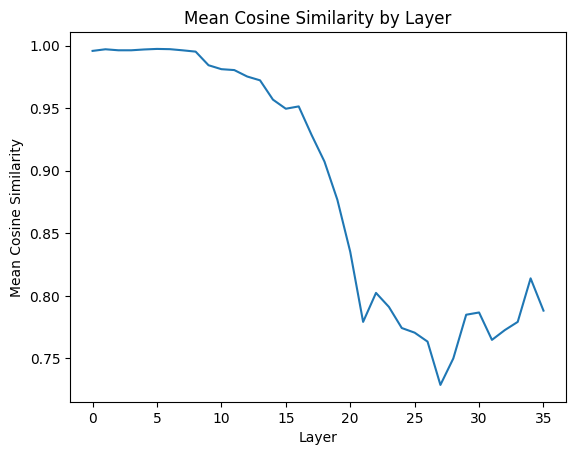

In [36]:
import matplotlib.pyplot as plt

# Extract means for plotting
means = [mean_std[L][0] for L in layers]

plt.plot(layers, means)
plt.xlabel('Layer')
plt.ylabel('Mean Cosine Similarity')
plt.title('Mean Cosine Similarity by Layer')
plt.show()


Cosine between mean residual directions:
Layer  0:  cos(mean_think, mean_nothink) = 0.9959
Layer  1:  cos(mean_think, mean_nothink) = 0.9973
Layer  2:  cos(mean_think, mean_nothink) = 0.9967
Layer  3:  cos(mean_think, mean_nothink) = 0.9967
Layer  4:  cos(mean_think, mean_nothink) = 0.9973
Layer  5:  cos(mean_think, mean_nothink) = 0.9977
Layer  6:  cos(mean_think, mean_nothink) = 0.9976
Layer  7:  cos(mean_think, mean_nothink) = 0.9968
Layer  8:  cos(mean_think, mean_nothink) = 0.9959
Layer  9:  cos(mean_think, mean_nothink) = 0.9857
Layer 10:  cos(mean_think, mean_nothink) = 0.9831
Layer 11:  cos(mean_think, mean_nothink) = 0.9827
Layer 12:  cos(mean_think, mean_nothink) = 0.9783
Layer 13:  cos(mean_think, mean_nothink) = 0.9766
Layer 14:  cos(mean_think, mean_nothink) = 0.9625
Layer 15:  cos(mean_think, mean_nothink) = 0.9576
Layer 16:  cos(mean_think, mean_nothink) = 0.9597
Layer 17:  cos(mean_think, mean_nothink) = 0.9376
Layer 18:  cos(mean_think, mean_nothink) = 0.9180
Layer 19

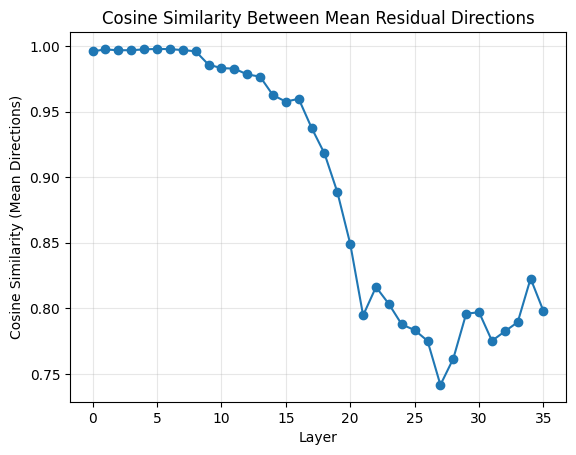

In [38]:
# Mean direction version
mean_dir = {}

for L in layers:
    think_stack = torch.stack([r[L][RES_KEY][:, -1, :].squeeze(0) for r in all_residuals])
    nothink_stack = torch.stack([r[L][RES_KEY][:, -1, :].squeeze(0) for r in all_residuals_nothink])

    mean_think = think_stack.mean(dim=0)
    mean_nothink = nothink_stack.mean(dim=0)

    sim = F.cosine_similarity(mean_think, mean_nothink, dim=0)
    mean_dir[L] = sim.item()

print("\nCosine between mean residual directions:")
for L in layers:
    print(f"Layer {L:>2}:  cos(mean_think, mean_nothink) = {mean_dir[L]:.4f}")

# Plot mean direction cosine similarities
mean_dir_values = [mean_dir[L] for L in layers]

plt.figure()
plt.plot(layers, mean_dir_values, marker='o')
plt.xlabel('Layer')
plt.ylabel('Cosine Similarity (Mean Directions)')
plt.title('Cosine Similarity Between Mean Residual Directions')
plt.grid(True, alpha=0.3)
plt.show()


In [29]:
# Load the saved residuals
think_data = torch.load('/mnt/SSD4/kartik/reasoning/residuals/residuals_think_Qwen_Qwen3-1.7B.pt')
nothink_data = torch.load('/mnt/SSD4/kartik/reasoning/residuals/residuals_nothink_Qwen_Qwen3-1.7B.pt')

/tmp/ipykernel_126035/551303806.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  think_data = torch.load('/mnt/SSD4/kartik/reasoning/residuals/residuals_think_Qwen_Qwen3-

In [30]:
nothink_data.keys()

dict_keys(['pre', 'post', 'eoi_token_ids', 'questions'])

In [33]:
nothink_data['pre'].shape, nothink_data['post'].shape, think_data['pre'].shape, think_data['post'].shape

(torch.Size([2, 28, 6, 2048]),
 torch.Size([2, 28, 6, 2048]),
 torch.Size([2, 28, 6, 2048]),
 torch.Size([2, 28, 6, 2048]))